
# Simulazione di caching basato su similarità di prompt (CLIP) con due politiche di eviction: LRU e LFU

## Prerequisiti:
  pip install huggingface_hub pandas transformers torch torchvision
Su macOS con MPS, installa torch con:
   pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/mps


In [130]:

import random
import pandas as pd
import torch
from huggingface_hub import hf_hub_download
from collections import OrderedDict, defaultdict
from transformers import CLIPTokenizer, CLIPModel



# 1) Setup device (MPS su Mac, altrimenti CPU)


In [131]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using Apple MPS device


# 2) Setup CLIP per embedding testuale

In [132]:
clip_model_name = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
model = CLIPModel.from_pretrained(clip_model_name).to(device)
model.eval()

def embed_prompt(prompt: str) -> torch.Tensor:
    """
    Ritorna embedding L2-normalizzato del prompt.
    """
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        emb = model.get_text_features(**inputs)
    return emb / emb.norm(p=2, dim=-1, keepdim=True)

### Gestione del dataset

In [133]:
from numpy import shape


class PromptDatasetManager:

    def __init__(self):
        """
        Inizializza il gestore del dataset dei prompt.
        """
        self.df = pd.DataFrame()
        self.meta_path = None

    def load_remote_metadata(self, repo_id: str, filename: str, max_rows: int = None):
        """
        Carica un file metadata.parquet da un repository remoto.
        Se `max_rows` è specificato, carica solo le prime `max_rows` righe.
        """
        print(f"Caricamento metadata da {repo_id}/{filename}...")
        self.meta_path = hf_hub_download(repo_id=repo_id, filename=filename)
        self.df = pd.read_parquet(self.meta_path).head(max_rows) if max_rows else pd.read_parquet(self.meta_path)
        print(f"Colonne disponibili: {list(self.df.columns)}\n")
        print(f"Dimensioni del DataFrame: {self.df.shape}")

    def load_local_metadata(self, path: str, max_rows: int = None):
        """
        Carica un file metadata.parquet locale.
        Se `max_rows` è specificato, carica solo le prime `max_rows` righe.
        """
        print(f"Caricamento metadata da {path}...")
        self.meta_path = path
        self.df = pd.read_parquet(self.meta_path).head(max_rows) if max_rows else pd.read_parquet(self.meta_path)
        print(f"Colonne disponibili: {list(self.df.columns)}\n")
        print(f"Dimensioni del DataFrame: {self.df.shape}")
    
    def get_path(self):
        """
        Restituisce il percorso del file metadata.parquet scaricato.
        """
        return self.meta_path

    def _get_user_sessions(self,
                          user_name: str,
                          session_gap: int = 30) -> pd.DataFrame:
        """
        Estrae dal DataFrame tutte le righe di un dato `user_name`, ordina per timestamp
        e assegna un `session_id` incrementale ogni volta che l'intervallo tra richieste
        successive supera `session_gap` minuti.
        Deve restituire tutte le sessioni per un utente specifico.
        """
        if 'user_name' not in self.df.columns or 'timestamp' not in self.df.columns:
            raise ValueError("Le colonne 'user_name' e/o 'timestamp' non sono presenti.")
        df_user = self.df[self.df['user_name'] == user_name].copy()
        if df_user.empty:
            raise ValueError(f"Nessun dato per l'utente {user_name}")
        df_user = df_user.sort_values('timestamp').reset_index(drop=True)
        # Calcola delta in minuti
        df_user['session_delta'] = df_user['timestamp'].diff().dt.total_seconds() / 60.0
        # Assegna session_id
        session_ids = []
        current_id = 0
        for delta in df_user['session_delta']:
            if pd.isna(delta) or delta > session_gap:
                current_id += 1
            session_ids.append(current_id)
        df_user['session_id'] = session_ids
        return df_user
    
    def executeFunctionOnDataFrame(self, func, *args, **kwargs):
        """
        Esegue una funzione `func` sul DataFrame e restituisce il risultato.
        La funzione deve accettare un DataFrame come primo argomento.
        """
        if not callable(func):
            raise ValueError("Il parametro 'func' deve essere una funzione chiamabile.")
        return func(self.df, *args, **kwargs)

    def  getDataFrame(self):
        """
        Restituisce il DataFrame completo.
        Se il DataFrame è molto grande, considera di usare `head()` per limitare le righe.
        """
        return self.df
    
    def getPrompts(self, limit: int = None, shuffle: bool = True):
        """
        Restituisce una lista di prompt dal DataFrame.
        Se `limit` è specificato, restituisce solo i primi `limit` prompt.
        """
        prompts = self.df['prompt'].dropna().tolist()
        if shuffle:
            random.shuffle(prompts)
        if limit is not None:
            prompts = prompts[:limit]
        return prompts
    
    def getUsersPrompts(self, limit: int = None, shuffle: bool = True):
        """
        Restituisce un dizionario di prompt per ogni utente.
        Ogni chiave è il nome dell'utente, e il valore è una lista di prompt.
        Se `limit` è specificato, restituisce solo i primi `limit` utenti.
        """
        user_prompts = {}
        users = self.df['user_name'].dropna().unique()
        if shuffle:
            random.shuffle(users)
        if limit is not None:
            users = users[:limit]
        for user in users:
            user_prompts[user] = self.df[self.df['user_name'] == user]['prompt'].dropna().tolist()
        return user_prompts
    
    def getSessionsPrompts(self, session_gap: int = 30, limit: int = None, shuffle: bool = True):
        """
        Restituisce un dizionario di sessioni per ogni utente.
        Ogni chiave è il nome dell'utente, e il valore è un dizionario con `session_id` come chiave
        e una lista di prompt come valore.
        Se `limit` è specificato, restituisce solo i primi `limit` utenti.
        """
        user_sessions = {}
        users = self.df['user_name'].dropna().unique()
        if shuffle:
            random.shuffle(users)
        if limit is not None:
            users = users[:limit]
        for user in users:
            df_user = self._get_user_sessions(user, session_gap=session_gap)
            if df_user.empty:
                continue
            sessions = defaultdict(list)
            for _, row in df_user.iterrows():
                sessions[row['session_id']].append(row['prompt'])
            user_sessions[user] = dict(sessions)
        return user_sessions
    
    def retRandomPrompt(self):
        """
        Restituisce una funzione lambda che, ad ogni chiamata,
        restituisce un nuovo prompt casuale dal database.
        """
        prompts = self.df['prompt'].dropna().tolist()
        return lambda: random.choice(prompts)
    
    def retRandomSession(self, session_gap: int = 30, max_prompts: int = None):
        """
        Restituisce una funzione che genera sessioni di un utente casuale.
        Ogni sessione ritorna i prompt di un utente casuale, se specificato,
        i prompt per ogni sessione sono limitati a `max_prompts.
        """
        users = self.df['user_name'].dropna().unique()
        if len(users) == 0:
            raise ValueError("Nessun utente trovato nel DataFrame.")
        
        def generate_session():
            user = random.choice(users)
            df_user = self._get_user_sessions(user, session_gap)
            if df_user.empty:
                raise ValueError(f"Nessuna sessione trovata per l'utente {user}")
            # Ritorno tutti i prompt della sessione se `max_prompts` non è specificato
            if max_prompts is None:
                return user, df_user['prompt'].dropna().tolist()
            # Altrimenti, ritorno tutti i prompt della sessione
            return 
        return generate_session

Funzione per calcolare gli embeddings CLIP e salvarli in un file Parquet.
Valuta direttamente supporti per TPU e GPU, altrimenti CPU.

In [134]:
import random
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from huggingface_hub import hf_hub_download
from collections import OrderedDict, defaultdict
from transformers import CLIPTokenizer, CLIPTextModel
import threading, queue, math
from tqdm import tqdm

# Se torch_xla è installato (TPU), importalo; altrimenti lo ignori
try:
    import torch_xla.core.xla_model as xm
    TPU_AVAILABLE = True
except ImportError:
    TPU_AVAILABLE = False



def add_clip_embeddings_auto(
    meta_path: str,
    output_path: str,
    batch_size: int = 4096,
    prefetch: int = 2
):
    """
    Streaming Parquet → batch → tokenizza su CPU → inferisce su
    TPU (torch_xla) / GPU (CUDA) / CPU → scrive parquet con colonna `clip_emb`.
    """
    reader = pq.ParquetFile(meta_path)
    total_rows    = reader.metadata.num_rows

    # --- Device selection e conteggio ---
    if TPU_AVAILABLE:
        device    = xm.xla_device()
        n_devices = xm.xrt_world_size()
        print(f"▶ Using TPU: {n_devices} core(s), device={device}")
    elif torch.cuda.is_available():
        n_devices = torch.cuda.device_count()
        device    = torch.device("cuda")
        names     = [torch.cuda.get_device_name(i) for i in range(n_devices)]
        print(f"▶ Using {n_devices} GPU(s): {names}")
    else:
        n_devices = 1
        device    = torch.device("cpu")
        print("▶ CUDA/TPU non disponibile, uso CPU")

    # Adatto batch_size a multiplo di n_devices
    per_dev_bs     = max(1, batch_size // n_devices)
    batch_size_glb = per_dev_bs * n_devices
    if batch_size_glb != batch_size:
        print(f"Aggiusto batch_size: {batch_size} → {batch_size_glb}  ({per_dev_bs}×{n_devices})")
    batch_size    = batch_size_glb
    total_batches = math.ceil(total_rows / batch_size)

    # --- Writer setup ---
    schema_out = reader.schema_arrow.append(
        pa.field("clip_emb", pa.list_(pa.float32()))
    )
    writer = pq.ParquetWriter(output_path, schema_out, compression=None)

    # --- Tokenizer & Model setup ---
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32") \
                            .to(device).half()
    if not TPU_AVAILABLE and n_devices > 1 and device.type == "cuda":
        model = torch.nn.DataParallel(model)
    model = torch.compile(model)
    model.eval()

    # Coda per pipeline producer/consumer
    q = queue.Queue(prefetch)

    def producer():
        for batch in reader.iter_batches(batch_size=batch_size):
            tbl     = pa.Table.from_batches([batch])
            prompts = tbl.column("prompt").to_pylist()
            toks    = tokenizer(prompts,
                                padding=True,
                                truncation=True,
                                return_tensors="pt")
            q.put((tbl, toks))
        q.put(None)

    def consumer():
        pbar = tqdm(total=total_batches, desc="CLIP embeddings", unit="batch")
        while True:
            item = q.get()
            if item is None:
                break
            tbl, toks = item
            toks = {k: v.to(device, non_blocking=True) for k, v in toks.items()}

            if TPU_AVAILABLE:
                with torch.no_grad():
                    emb = model(**toks).pooler_output.cpu().numpy()
            else:
                # mixed‑precision solo su CUDA
                with torch.cuda.amp.autocast(enabled=(device.type=="cuda")), torch.no_grad():
                    emb = model(**toks).pooler_output.cpu().numpy()

            tbl = tbl.append_column(
                "clip_emb",
                pa.array(emb.tolist(), type=pa.list_(pa.float32()))
            )
            writer.write_table(tbl)
            pbar.update(1)
        pbar.close()
        writer.close()

    t1 = threading.Thread(target=producer, daemon=True)
    t2 = threading.Thread(target=consumer, daemon=True)
    t1.start(); t2.start()
    t1.join(); t2.join()

    # Ricarico in pandas per usi successivi
    print(f"Embeddings calcolati e salvati in: {output_path}")
    return pd.read_parquet(output_path)




In [ ]:
manager = PromptDatasetManager()
manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Code/dataset.parquet",
    max_rows=None # Limita per testare velocemente
)

# Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

In [135]:
import torch.nn.functional as F

class SimilarityLRUCache:
    """Cache similarity + eviction LRU"""
    def __init__(self, capacity: int, threshold: float):
        self.capacity = capacity
        self.threshold = threshold
        # ordered dict: prompt -> (embedding)
        self.cache = OrderedDict()

    def query(self, prompt: str) -> bool:
        """
        Se esiste un item in cache con sim >= threshold -> hit, aggiorna MRU.
        Altrimenti -> miss.
        """
        q_emb = embed_prompt(prompt)
        best_key, best_sim = None, -1.0
        # cerca best match
        for key, emb in self.cache.items():
            sim = float((emb @ q_emb.T).item())
            if sim > best_sim:
                best_key, best_sim = key, sim
        if best_sim >= self.threshold:
            # hit: aggiorna ordine
            self.cache.move_to_end(best_key)
            return True
        # miss
        self._add(prompt, q_emb)
        return False

    def _add(self, prompt: str, emb: torch.Tensor):
        if len(self.cache) >= self.capacity:
            # rimuovi LRU
            self.cache.popitem(last=False)
        self.cache[prompt] = emb

class SimilarityLFUCache:
    """Cache similarity + eviction LFU"""
    def __init__(self, capacity: int, threshold: float):
        self.capacity = capacity
        self.threshold = threshold
        # store prompt -> embedding, and freq count
        self.cache = {}
        self.freq = defaultdict(int)

    def query(self, prompt: str) -> bool:
        q_emb = embed_prompt(prompt)
        best_key, best_sim = None, -1.0
        for key, emb in self.cache.items():
            sim = float((emb @ q_emb.T).item())
            if sim > best_sim:
                best_key, best_sim = key, sim
        if best_sim >= self.threshold:
            # hit: incrementa freq
            self.freq[best_key] += 1
            return True
        # miss
        self._add(prompt, q_emb)
        return False

    def _add(self, prompt: str, emb: torch.Tensor):
        if len(self.cache) >= self.capacity:
            # rimuovi LFU
            min_freq = min(self.freq.values())
            # trova una chiave con freq minima
            for key, f in list(self.freq.items()):
                if f == min_freq:
                    del self.cache[key]
                    del self.freq[key]
                    break
        self.cache[prompt] = emb
        self.freq[prompt] = 1


class SimilarityTTLCache:
    """Cache similarity + eviction TTL (in numero di richieste)"""
    def __init__(self, capacity: int, threshold: float, ttl: int):
        self.capacity = capacity
        self.threshold = threshold
        self.ttl = ttl
        self.cache = {}    # prompt -> emb (1‑D tensor)
        self.seen = {}     # prompt -> last_seen_request_index

    def query(self, prompt: str, t: int) -> bool:
        # 1) expire old entries
        expired = [p for p, ts in self.seen.items() if t - ts > self.ttl]
        for p in expired:
            del self.cache[p]
            del self.seen[p]

        # 2) similarity search
        q_emb = embed_prompt(prompt).squeeze()
        best_key, best_sim = None, -1.0
        for key, emb in self.cache.items():
            emb = emb.squeeze()
            sim = F.cosine_similarity(q_emb.unsqueeze(0), emb.unsqueeze(0), dim=1).item()
            if sim > best_sim:
                best_sim, best_key = sim, key

        if best_sim >= self.threshold:
            self.seen[best_key] = t
            return True

        # MISS: aggiungi (ed eventualmente evict)
        if len(self.cache) >= self.capacity:
            oldest = min(self.seen, key=lambda k: self.seen[k])
            del self.cache[oldest]; del self.seen[oldest]
        self.cache[prompt] = q_emb
        self.seen[prompt] = t
        return False



### Chaching test

In [137]:
random.seed(42)
NUM_REQUESTS  = 200      # numero di richieste da simulare
CACHE_SIZE    = 50       # dimensione cache
SIM_THRESHOLD = 0.8      # soglia di similarità
TTL_VALUES    = [10, 50, 100, 200]  # diversi TTL da testare

# prepariamo prompt generator
prompt_fn = manager.retRandomPrompt()

# funzioni di simulazione
def simulate_standard(cache_obj):
    hits = 0
    for _ in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache_obj.query(p):
            hits += 1
    return hits / NUM_REQUESTS

def simulate_ttl(ttl):
    cache = SimilarityTTLCache(CACHE_SIZE, SIM_THRESHOLD, ttl)
    hits = 0
    for t in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache.query(p, t):
            hits += 1
    return hits / NUM_REQUESTS

# esegui simulazioni
results = {}

# LRU e LFU
results["LRU"] = simulate_standard(SimilarityLRUCache(CACHE_SIZE, SIM_THRESHOLD))
results["LFU"] = simulate_standard(SimilarityLFUCache(CACHE_SIZE, SIM_THRESHOLD))

# TTL per vari parametri
for ttl in TTL_VALUES:
    results[f"TTL={ttl}"] = simulate_ttl(ttl)

# stampa tabella
import pandas as pd
df_res = pd.DataFrame([
    {"policy": k, "hit_rate": v} for k, v in results.items()
])
print(df_res)


    policy  hit_rate
0      LRU     0.000
1      LFU     0.020
2   TTL=10     0.005
3   TTL=50     0.005
4  TTL=100     0.030
5  TTL=200     0.030


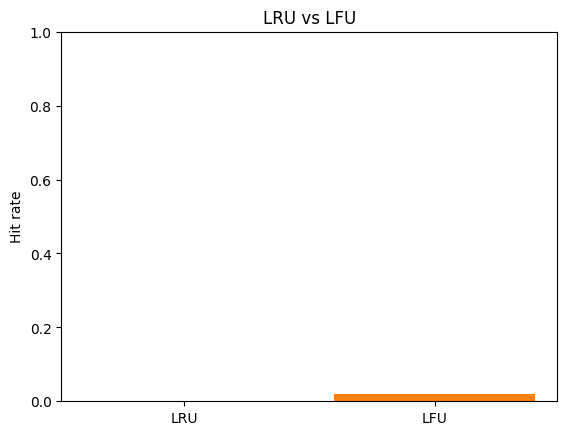

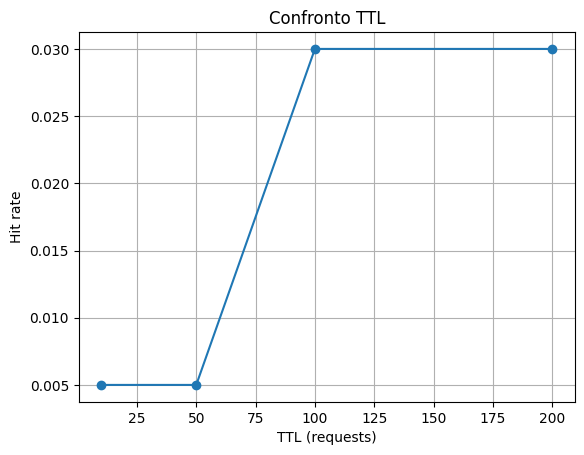

In [138]:
# %% [markdown]
# ## 5) Plot dei risultati

# %% [code]
import matplotlib.pyplot as plt

# separa LRU/LFU
plt.figure()
for pol in ["LRU", "LFU"]:
    hr = df_res[df_res.policy==pol].hit_rate.values[0]
    plt.bar(pol, hr)
plt.ylim(0,1)
plt.ylabel("Hit rate")
plt.title("LRU vs LFU")
plt.show()

# plot TTL
plt.figure()
ttl_rows = df_res[df_res.policy.str.startswith("TTL=")]
vals = [float(x.split("=")[1]) for x in ttl_rows.policy]
hrs  = ttl_rows.hit_rate.tolist()
plt.plot(vals, hrs, marker="o")
plt.xlabel("TTL (requests)")
plt.ylabel("Hit rate")
plt.title("Confronto TTL")
plt.grid(True)
plt.show()


# Valutazione della similarità intra-sessione, extra-sessione e same-user

In [ ]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_intra_session_sims(
    manager,
    num_sessions: int = 50,
    session_gap: int = 30,
    max_prompts: int = 20
) -> list[float]:
    """
    Estrae fino a `num_sessions` sessioni casuali (gap = session_gap minuti),
    calcola per ognuna la similarità coseno media tra prompt consecutivi
    (fino a `max_prompts` per sessione) e restituisce la lista dei valori.
    """
    intra_sims = []
    count = 0

    user_sessions = manager.getSessionsPrompts(
        session_gap=session_gap,
        limit=num_sessions,
        shuffle=True
    )
    for user, sessions in user_sessions.items():
        for sess_id, prompts in sessions.items():
            if len(prompts) < 2:
                continue
            prompts = prompts[:max_prompts]
            embs = torch.cat([embed_prompt(p) for p in prompts], dim=0)
            sims = [
                float((embs[i] @ embs[i-1].T).item())
                for i in range(1, embs.size(0))
            ]
            if sims:
                intra_sims.append(np.mean(sims))
                count += 1
            if count >= num_sessions:
                break
        if count >= num_sessions:
            break

    return intra_sims


def compute_extra_session_sims(
    manager,
    num_pairs: int = 50
) -> list[float]:
    """
    Estrae 2*num_pairs prompt casuali (da utenti qualsiasi),
    forma num_pairs coppie consecutive e calcola la similarità coseno
    per ogni coppia, restituendo la lista dei valori.
    """
    extra_sims = []
    prompts = manager.getPrompts(limit=2 * num_pairs, shuffle=True)
    for i in range(0, 2 * num_pairs, 2):
        emb1 = embed_prompt(prompts[i])
        emb2 = embed_prompt(prompts[i + 1])
        sim = float((emb1 @ emb2.T).item())
        extra_sims.append(sim)
    return extra_sims


def compute_user_sims(
    manager,
    num_pairs: int = 50
) -> list[float]:
    """
    Similarità fra prompt *dello stesso* utente, presi a coppie casuali.
    """
    user_sims = []
    count = 0

    user_prompts = manager.getUsersPrompts(limit=num_pairs*2, shuffle=True)
    # itero sugli utenti finché non ho num_pairs valori
    for user, prompts in user_prompts.items():
        if len(prompts) < 2:
            continue
        # generiamo al massimo una coppia per utente per volta
        while count < num_pairs and len(prompts) >= 2:
            p1, p2 = random.sample(prompts, 2)
            emb1 = embed_prompt(p1)
            emb2 = embed_prompt(p2)
            sim = float((emb1 @ emb2.T).item())
            user_sims.append(sim)
            count += 1
        if count >= num_pairs:
            break

    return user_sims


In [151]:
# Calcolo dati
print("Calcolo similarità intra-sessione...")
intra = compute_intra_session_sims(manager, num_sessions=20, session_gap=30, max_prompts=20)
print("Calcolo similarità extra-sessione...")
extra = compute_extra_session_sims(manager, num_pairs=50)
print("Calcolo similarità same-user...")
user = compute_user_sims(manager, num_pairs=50)
print("Calcolo completato.")

Calcolo similarità intra-sessione...
Calcolo similarità extra-sessione...
Calcolo similarità same-user...
Calcolo completato.


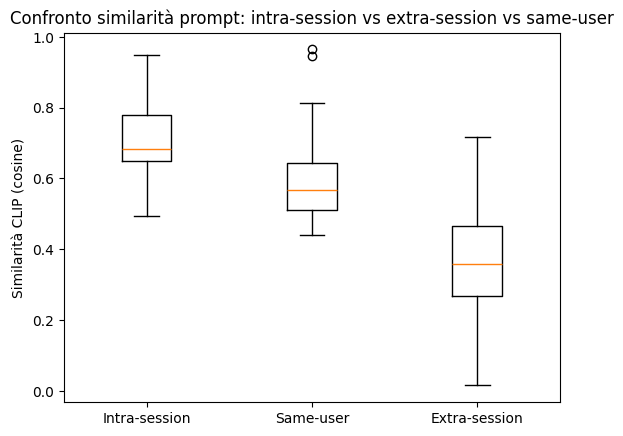

In [152]:

def plot_session_similarity(
    intra_sims: list[float],
    extra_sims: list[float],
    user_sims:  list[float]
) -> None:
    """
    Boxplot comparativo delle tre distribuzioni:
      - Intra-session
      - Extra-session
      - Same-user (senza sessione)
    """
    plt.figure()
    plt.boxplot(
        [intra_sims, user_sims, extra_sims],
        tick_labels=['Intra-session', 'Same-user', 'Extra-session']
    )
    plt.ylabel("Similarità CLIP (cosine)")
    plt.title("Confronto similarità prompt: intra-session vs extra-session vs same-user")
    plt.show()
    
# Disegno boxplot comparativo
plot_session_similarity(intra, extra, user)

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Definisci i gap da testare
session_gaps = [5, 10, 20, 30, 60, 120]

# 2) Calcola per ogni gap la lista delle intra‐sims
sims_by_gap = {
    gap: compute_intra_session_sims(manager, num_sessions=50, session_gap=gap, max_prompts=None)
    for gap in session_gaps
}

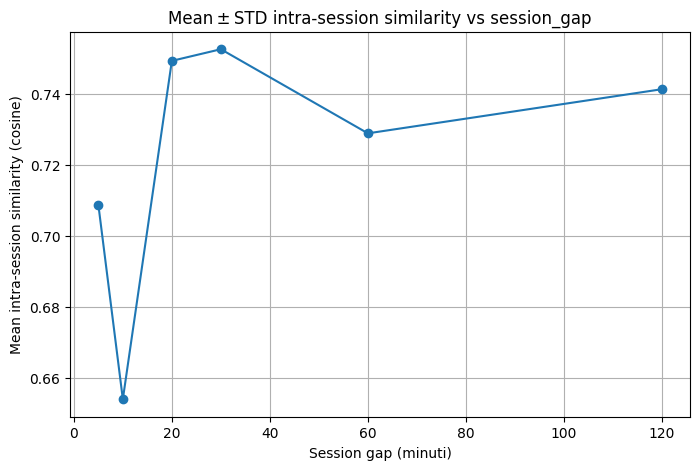

Miglior session_gap = 30 min  (mean sim = 0.7525)


In [163]:

# 3) Estrai mean e std
means = []
for gap in session_gaps:
    vals = sims_by_gap[gap]
    means.append(np.mean(vals) if vals else 0.0)

# 4) Plotta mean ± std
plt.figure(figsize=(8,5))
plt.errorbar(
    session_gaps, means,
    marker='o', linestyle='-', capsize=5
)
plt.xlabel("Session gap (minuti)")
plt.ylabel("Mean intra‐session similarity (cosine)")
plt.title("Mean ± STD intra‐session similarity vs session_gap")
plt.grid(True)
plt.show()

# 5) Evidenzia il gap con mean massima
best_gap = session_gaps[np.argmax(means)]
print(f"Miglior session_gap = {best_gap} min  (mean sim = {means[session_gaps.index(best_gap)]:.4f})")
